In [9]:
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("data/Ethereum_4_7_2018-6_6_2018_historical_data_coinmarketcap.csv")
data.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-08-29T00:00:00.000Z,2024-08-29T23:59:59.999Z,2024-08-29T15:35:00.000Z,2024-08-29T22:10:00.000Z,2781,2528.362339,2595.976950,2507.502461,2528.792715,13946434277,3.042030e+11,2024-08-29T23:59:59.999Z
1,2024-08-28T00:00:00.000Z,2024-08-28T23:59:59.999Z,2024-08-28T21:27:00.000Z,2024-08-28T01:38:00.000Z,2781,2458.904729,2553.820133,2422.293631,2528.415504,20359545410,3.041590e+11,2024-08-28T23:59:59.999Z
2,2024-08-27T00:00:00.000Z,2024-08-27T23:59:59.999Z,2024-08-27T05:52:00.000Z,2024-08-27T22:16:00.000Z,2781,2681.622855,2700.152794,2401.175001,2458.726473,18028996056,2.958040e+11,2024-08-27T23:59:59.999Z
3,2024-08-26T00:00:00.000Z,2024-08-26T23:59:59.999Z,2024-08-26T00:36:00.000Z,2024-08-26T21:23:00.000Z,2781,2749.247573,2763.004177,2668.886669,2681.340514,12282035835,3.225970e+11,2024-08-26T23:59:59.999Z
4,2024-08-25T00:00:00.000Z,2024-08-25T23:59:59.999Z,2024-08-25T21:23:00.000Z,2024-08-25T07:39:00.000Z,2781,2769.098245,2793.012985,2736.088941,2749.157667,9375535539,3.307190e+11,2024-08-25T23:59:59.999Z


In [11]:
data.shape

(2336, 12)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeOpen   2336 non-null   object 
 1   timeClose  2336 non-null   object 
 2   timeHigh   2336 non-null   object 
 3   timeLow    2336 non-null   object 
 4   name       2336 non-null   int64  
 5   open       2336 non-null   float64
 6   high       2336 non-null   float64
 7   low        2336 non-null   float64
 8   close      2336 non-null   float64
 9   volume     2336 non-null   int64  
 10  marketCap  2336 non-null   float64
 11  timestamp  2336 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 219.1+ KB


In [13]:
data["timeopen"] = pd.to_datetime(data["timeOpen"])
print(data["timeopen"])
print("Initial date:",data["timeopen"].min())
print("End date:",data["timeopen"].max())

0      2024-08-29 00:00:00+00:00
1      2024-08-28 00:00:00+00:00
2      2024-08-27 00:00:00+00:00
3      2024-08-26 00:00:00+00:00
4      2024-08-25 00:00:00+00:00
                  ...           
2331   2018-04-12 00:00:00+00:00
2332   2018-04-11 00:00:00+00:00
2333   2018-04-10 00:00:00+00:00
2334   2018-04-09 00:00:00+00:00
2335   2018-04-08 00:00:00+00:00
Name: timeopen, Length: 2336, dtype: datetime64[ns, UTC]
Initial date: 2018-04-08 00:00:00+00:00
End date: 2024-08-29 00:00:00+00:00


In [14]:
data["name"] = data["name"].astype(str)

In [15]:
data.describe()

,open,high,low,close,volume,marketCap
count,2336.000000,2336.000000,2336.000000,2336.000000,2.336000e+03,2.336000e+03
mean,1463.420970,1502.762165,1420.148014,1464.122492,1.303476e+10,1.733567e+11
std,1230.191451,1263.425107,1192.417982,1229.872068,9.995172e+09,1.477368e+11
min,84.279694,85.342743,82.829890,84.308296,9.484880e+08,8.751210e+09
25%,237.721675,243.720758,231.337888,237.763124,6.127227e+09,2.611588e+10
50%,1389.196389,1455.205366,1334.236817,1403.829157,1.080299e+10,1.673735e+11
75%,2299.610834,2355.889448,2214.482448,2299.563531,1.755068e+10,2.732298e+11
max,4810.071533,4891.704698,4718.039256,4812.087614,8.448291e+10,5.690940e+11


In [16]:
data['timeopen'] = pd.to_datetime(data['timeopen']).dt.date
print(data["timeopen"].head())
data['timeclose'] = pd.to_datetime(data['timeClose']).dt.date
print(data["timeclose"].head())
data['timehigh'] = pd.to_datetime(data['timeHigh']).dt.date
print(data["timehigh"].head())
data['timelow'] = pd.to_datetime(data['timeLow']).dt.date
print(data["timelow"].head())

0    2024-08-29
1    2024-08-28
2    2024-08-27
3    2024-08-26
4    2024-08-25
Name: timeopen, dtype: object
0    2024-08-29
1    2024-08-28
2    2024-08-27
3    2024-08-26
4    2024-08-25
Name: timeclose, dtype: object
0    2024-08-29
1    2024-08-28
2    2024-08-27
3    2024-08-26
4    2024-08-25
Name: timehigh, dtype: object
0    2024-08-29
1    2024-08-28
2    2024-08-27
3    2024-08-26
4    2024-08-25
Name: timelow, dtype: object


In [17]:
data["timelow"] = data["timelow"].astype(str)
data["date of year"] = data["timelow"].str.split("-").str[0]
print(data["date of year"].unique())
data["timelow"] = data["timelow"].astype(str)
data["date of month"] = data["timelow"].str.split("-").str[1]
print(data["date of month"].unique())

['2024' '2023' '2022' '2021' '2020' '2019' '2018']
['08' '07' '06' '05' '04' '03' '02' '01' '12' '11' '10' '09']


In [18]:
data['date'] = pd.to_datetime(data['date of year'].astype(str) + '-' + data['date of month'].astype(str))
data['date'].head()

,date
0,2024-08-01
1,2024-08-01
2,2024-08-01
3,2024-08-01
4,2024-08-01


In [19]:
data = data.sort_values(by='timeopen', ascending=True)

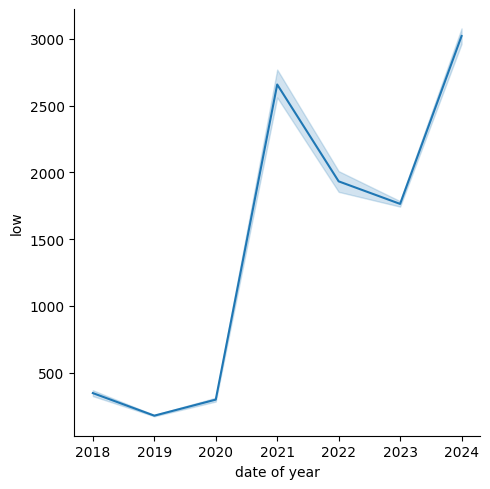

In [20]:
sns.relplot(data=data[["low","date of year"]], x = "date of year",y = "low",kind = "line")
plt.show()

In [21]:
data = data.sort_values(by='date of month')
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['open'], high=data['high'],
                low=data['low'], close=data['close'])
                      ])
fig.show()

In [22]:
data['timeopen'] = pd.to_datetime(data['timeopen']).apply(lambda x: x.timestamp())
data['timeclose'] = pd.to_datetime(data['timeclose']).apply(lambda x: x.timestamp())
data['timehigh'] = pd.to_datetime(data['timehigh']).apply(lambda x: x.timestamp())
data['timelow'] = pd.to_datetime(data['timelow']).apply(lambda x: x.timestamp())

In [23]:
data.rename(columns={'timeopen': 'Date'}, inplace=True)

In [24]:
data['Date'] = pd.to_datetime(data['Date'], unit='s')
data = data.sort_values(by='Date')

In [25]:
data_face = data[['Date','close']]
print("Shape of close dataframe:", data_face.shape)

Shape of close dataframe: (2336, 2)


In [26]:
fig = px.line(data_face, x=data_face.Date, y=data_face.close,labels={'date':'Date','close':'price'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of ethereum close price 2018-2024', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume']])

In [28]:
def create_sequences(data, time_step=3):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :-1])
        y.append(data[i + time_step, -2])
    return np.array(X), np.array(y)

In [29]:
time_step = 3
X, y = create_sequences(scaled_data, time_step)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the close price

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0566 - val_loss: 9.8985e-04
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 7.5140e-04
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 6.1853e-04
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 7.0694e-04
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 5.6374e-04
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 5.6959e-04
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 6.3651e-04
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 7.7812e-04
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 5.9726e-04
Epoch 12/200
55/55 ━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
predicted_prices = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_prices)
mse = mean_squared_error(y_test, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predicted_prices)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


In [ ]:
predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
X_last = X_test[:, -1, :-1]
predicted_prices_full = np.concatenate((X_last, predicted_prices_reshaped), axis=1)

In [ ]:
last_known_values = scaled_data[-1, :-1]
dummy_other_features = np.tile(last_known_values, (predicted_prices.shape[0], 1))
predicted_prices_full = np.concatenate((dummy_other_features, predicted_prices), axis=1)
predicted_prices_rescaled = scaler.inverse_transform(predicted_prices_full)[:, -1]

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(predicted_prices_rescaled, color='red', label='Predicted Close Price for Next Year')
plt.title('Ethereum Price Prediction for the Next Year')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
data.head()